In [1]:
#Importing required libraries

import librosa
import IPython.display as ipd 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip

#### Extracting audio from the video file. (.mp3, .wav)


In [2]:
#load audio in a wave format as y 
#https://librosa.org/blog/2019/07/17/resample-on-load/#:~:text=The%20sampling%20rate%20%2D%2D%2D%20typically,in%20the%20discretely%20sampled%20signal.
#sampling rate is variable. We can play around it. 

y, s_rate = librosa.load("match_audio.mp3", sr=44100)
y.shape

(287862750,)

#### Break the audio into chunks

In [6]:
#now break audio into chunk of 15sec each to observe the pitch variation or rise in audio in our input signal

slice = 15
window_length = slice * s_rate

#just check whether slicing is properly working or not
array = y[15 * window_length : 16 * window_length]
ipd.Audio(array, rate=s_rate)

#### Compute the energy for calucualted chunks. 


![alt text](image.png)

In [7]:
#Now calculate energ for each chunk we have divided

Energy_2 = np.array([sum(abs(y[i : i + window_length]**2)) for i in range(0, len(y), window_length)])
print("Energy of {} chunks is as follows {}".format((y.shape[0] / window_length), Energy_2))

Energy of 435.1666666666667 chunks is as follows [503.2223427  484.2282083  507.55375261 421.71254065 427.4233011
 490.25127438 445.19285522 486.31802723 350.29312975 358.09646585
 636.03075325 386.71415295 456.29320552 348.3680488  453.83143349
 329.81572041 438.63227531 455.840845   563.98079922 342.421027
 438.20692059 472.72692593 481.72700063 500.63143656 490.78247884
 423.86736462 322.59628289 425.27022488 372.29124391 424.94752452
 352.6473832  419.28493553 501.16078085 341.75471818 461.57824406
 264.55498911 389.29666496 293.79937191 341.18936836 505.31254551
 259.50432676 423.88884585 535.67616006 319.18157257 359.04949102
 611.83784103 544.31360411 410.12005323 452.09207234 344.41405416
 277.25872206 330.62446196 317.63540749 342.3729314  333.12777079
 279.95258965 252.62922835 118.3049597  422.12414985 246.23426789
 260.60836368 301.66842673 466.37063878 215.15098161 525.09100588
 489.80313328 481.1297125  297.5751108  326.61496641 382.54916354
 395.43464078 381.08308169 567

#### RMSE (Root Mean Square Energy)

In [3]:
#make a function to calculate an energy of a signal.

def rms_energy(arr, window_size):

    res = []

    for i in range(0, len(arr), window_size):
        current_value = arr[i:i+ window_size]
        rmse_val = np.sqrt(1 / len(current_value) * sum(i**2 for i in current_value))
        res.append(rmse_val)

    return np.array(res)


In [8]:
energy = rms_energy(y, window_size=window_length)
len(energy)

#### Plot the energy to find out the threshold value 

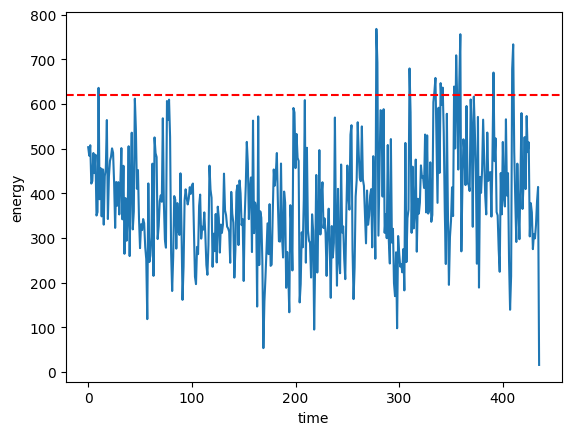

In [8]:
#plot histogram
threshold = 620
plt.plot(Energy_2)
plt.xlabel('time')
plt.ylabel('energy')
plt.axhline(threshold, color = 'red', linestyle = '--')

#### Classify clips as excitement or not depending on the threshold value which we have decided.

In [10]:
#create a dataframe to store these high pitch value 

pitch_df = pd.DataFrame(columns=['energy', 'Start', 'End'])
#low_threshold = 80
threshold = 620
index = 0

for i in range(len(Energy_2)):
    value = Energy_2[i]
    if value >= threshold:
        i = np.where(Energy_2 == value)[0]
        pitch_df.loc[index, 'energy'] = value
        pitch_df.loc[index, 'Start'] = i[0] * 10
        pitch_df.loc[index, 'End'] = (i[0]+1) * 10
        index = index + 1
pitch_df

,energy,Start,End
0,636.030753,100,110
1,767.98877,2780,2790
2,692.244873,2790,2800
3,679.505378,3100,3110
4,627.63369,3340,3350
5,658.227716,3350,3360
6,646.651582,3400,3410
7,636.596326,3420,3430
8,638.984792,3530,3540
9,708.895233,3550,3560


#### Lets merge consecutive clips depending on the time intervals 

In [11]:
# Now we will check the excitment snippets

temp = []
i = 0
j = 0
n = len(pitch_df) - 2
m = len(pitch_df) - 1

while (i <= n):
    j = i + 1
    while (j <= m):
        if(pitch_df['End'][i] == pitch_df['Start'][j]):
            pitch_df.loc[i, 'End'] = pitch_df.loc[j, 'End']
            temp.append(j)
            j = j + 1
        else:
            i = j
            break

pitch_df.drop(temp, axis=0, inplace=True)
print(pitch_df)

        energy Start   End
0   636.030753   100   110
1    767.98877  2780  2800
3   679.505378  3100  3110
4    627.63369  3340  3360
6   646.651582  3400  3410
7   636.596326  3420  3430
8   638.984792  3530  3540
9   708.895233  3550  3560
10  645.520472  3580  3600
12  670.291462  3910  3920
13  677.562946  4090  4110


#### Now will extract video clips from our actual video

In [20]:
# Now the final part lets generate highlights from the chunks 

start = np.array(pitch_df['Start'])
end = np.array(pitch_df['End'])

for i in range(len(pitch_df)):
    if i!= 0:
        start_lim = start[i] - 10
    else:
        start_lim = start[i]
    end_lim = end[i]

    filename = "HL_44k_" + str(i+1) + ".mp4"
    ffmpeg_extract_subclip("C:/Users/Hello/Match Highlights/match 2021/NBA_2021.mp4", start_lim, end_lim, targetname=filename)

Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join

In [10]:
from moviepy.editor import VideoFileClip, concatenate_videoclips

clip1 = VideoFileClip("C:/Users/Hello/Match Highlights/HL1.mp4")
clip2 = VideoFileClip("C:/Users/Hello/Match Highlights/HL2.mp4")
clip3 = VideoFileClip("C:/Users/Hello/Match Highlights/HL3.mp4")
clip4 = VideoFileClip("C:/Users/Hello/Match Highlights/HL4.mp4")
clip5 = VideoFileClip("C:/Users/Hello/Match Highlights/HL5.mp4")
clip6 = VideoFileClip("C:/Users/Hello/Match Highlights/HL6.mp4")
clip7 = VideoFileClip("C:/Users/Hello/Match Highlights/HL7.mp4")
clip8 = VideoFileClip("C:/Users/Hello/Match Highlights/HL8.mp4")
clip9 = VideoFileClip("C:/Users/Hello/Match Highlights/HL9.mp4")
clip10 = VideoFileClip("C:/Users/Hello/Match Highlights/HL10.mp4")
clip11 = VideoFileClip("C:/Users/Hello/Match Highlights/HL11.mp4")
clip12 = VideoFileClip("C:/Users/Hello/Match Highlights/HL12.mp4")
clip13 = VideoFileClip("C:/Users/Hello/Match Highlights/HL13.mp4")
clip14 = VideoFileClip("C:/Users/Hello/Match Highlights/HL14.mp4")
clip15 = VideoFileClip("C:/Users/Hello/Match Highlights/HL15.mp4")
clip16 = VideoFileClip("C:/Users/Hello/Match Highlights/HL16.mp4")
clip17 = VideoFileClip("C:/Users/Hello/Match Highlights/HL17.mp4")
clip18 = VideoFileClip("C:/Users/Hello/Match Highlights/HL18.mp4")
clip19 = VideoFileClip("C:/Users/Hello/Match Highlights/HL19.mp4")
clip20 = VideoFileClip("C:/Users/Hello/Match Highlights/HL20.mp4")
clip21 = VideoFileClip("C:/Users/Hello/Match Highlights/HL21.mp4")
clip22 = VideoFileClip("C:/Users/Hello/Match Highlights/HL22.mp4")
clip23 = VideoFileClip("C:/Users/Hello/Match Highlights/HL23.mp4")
clip24 = VideoFileClip("C:/Users/Hello/Match Highlights/HL24.mp4")
clip25 = VideoFileClip("C:/Users/Hello/Match Highlights/HL25.mp4")
clip26 = VideoFileClip("C:/Users/Hello/Match Highlights/HL26.mp4")
clip27 = VideoFileClip("C:/Users/Hello/Match Highlights/HL27.mp4")
clip28 = VideoFileClip("C:/Users/Hello/Match Highlights/HL28.mp4")
clip29 = VideoFileClip("C:/Users/Hello/Match Highlights/HL29.mp4")
clip30 = VideoFileClip("C:/Users/Hello/Match Highlights/HL30.mp4")
clip31 = VideoFileClip("C:/Users/Hello/Match Highlights/HL31.mp4")
clip32 = VideoFileClip("C:/Users/Hello/Match Highlights/HL32.mp4")
clip33 = VideoFileClip("C:/Users/Hello/Match Highlights/HL33.mp4")


final_clip = concatenate_videoclips([clip1,clip2,clip3,clip4,clip5,clip6,clip7,clip8,clip9,clip9,clip10,clip11,clip12,clip13,clip14,
                                     clip15,clip16,clip17, clip18,clip19,clip20, clip21,clip22,clip23,clip24,clip25,clip26,clip27,clip28,
                                     clip29,clip30,clip31,clip32,clip33])
final_clip.write_videofile("C:/Users/Hello/Match Highlights/final_highlights_ver2.mp4")

Moviepy - Building video C:/Users/Hello/Match Highlights/final_highlights_ver2.mp4.
MoviePy - Writing audio in final_highlights_ver2TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video C:/Users/Hello/Match Highlights/final_highlights_ver2.mp4



Moviepy - Done !
Moviepy - video ready C:/Users/Hello/Match Highlights/final_highlights_ver2.mp4
